In [1]:
import cvxpy as cp
import numpy as np

In [4]:
N = 10
K = 2

In [5]:
from collections import defaultdict
ALL_ITEMS = np.arange(N)
def update(action, item_selected, posterior_parameters, epoch_picks):
    if item_selected == N:
        n_is = [
            int(ix in action) for ix in range(N)
        ]
        v_is = [epoch_picks[i] for i in range(N)]
        posterior_parameters = [
            (a + n_is[ix], b + v_is[ix])
            for ix, (a, b) in enumerate(posterior_parameters)
        ]
        epoch_picks = defaultdict(int)
        epoch_ended = True
    else:
        epoch_picks[item_selected] += 1
        epoch_ended = False
    return posterior_parameters, epoch_picks, epoch_ended

def propose():
    return np.random.choice(
        np.arange(N, dtype=int),
        size=K,
        replace=False,
    )

def step(action, preferences):
    assert preferences[N] == 1.0
    possible_items = np.concatenate(
        [np.array([N], dtype=int), ALL_ITEMS[action]]
    )  # "no item" can always happen
    subset_preferences = preferences[possible_items]
    sum_preferences = subset_preferences.sum()
    probabilities = subset_preferences / sum_preferences
    return np.random.choice(possible_items, size=1, p=probabilities)[0]

def simulation(n_steps):
    preferences = np.random.rand(N + 1)
    preferences[-1] = 1.0
    posterior_parameters = [(4, 2) for _ in range(N)]
    epoch_picks = defaultdict(int)
    epoch_ended = True
    current_action = None
    for _ in range(n_steps):
        if epoch_ended:
            current_action = propose()
        item_picked = step(action=current_action,
                           preferences=preferences)
        posterior_parameters, epoch_picks, epoch_ended = update(action=current_action,
                                                                item_selected=item_picked,
                                                                posterior_parameters=posterior_parameters,
                                                                epoch_picks=epoch_picks)
    return preferences, posterior_parameters

def params_to_gaussian(posterior):
    gaussian_stds = np.array(
        [
            np.sqrt(b_ / a_ * ((b_ / a_) + 1) / a_)
            for (a_, b_) in posterior
        ],
    )
    gaussian_means = np.array(
        [b_ / a_ for (a_, b_) in posterior],
    )
    return gaussian_means, gaussian_stds

In [6]:
def sample_action(agent, posterior):
    agent.posterior_parameters = posterior
    return agent.proposal()

In [7]:
import matplotlib.pyplot as plt
from scipy.stats import norm, beta

def plot_posterior(means, stds, indices=np.arange(N), ground_truth=None):
    plt.figure(figsize=(len(indices), 5))
    discretization_size = 50
    x_vals = np.linspace(0., 1., num=discretization_size)
    y_vals = []
    for ix in range(len(indices)):
        y_vals.append(norm.pdf(x_vals, loc=means[ix], scale=stds[ix])) 
    x_vals = np.concatenate([x_vals + ix for ix in range(len(indices))])
    y_vals = np.concatenate(y_vals)
    plt.plot(x_vals, y_vals)
    if ground_truth is not None:
        x_truths = [true_param + ix for ix, true_param in enumerate(ground_truth)]
        plt.vlines(x=x_truths, ymin=0., ymax=y_vals.max(), color='red', linestyles='dashed')
    plt.xticks(ticks=np.arange(len(indices)), labels=indices)
    plt.grid()
    plt.show()
    plt.close()

In [8]:
pref, posterior = simulation(50)

In [9]:
pref

array([0.33959634, 0.86296695, 0.91287388, 0.39161146, 0.39075559,
       0.70858509, 0.10794141, 0.29643554, 0.45685289, 0.07863612,
       1.        ])

In [10]:
# posterior = [
#     (10, 8),
#     (10, 7),
#     (10, 5),
#     (1, 1),
#     (2, 1),
# ]

In [11]:
means, stds = params_to_gaussian(posterior)
means, stds

(array([0.9       , 0.5       , 0.77777778, 0.22222222, 0.33333333,
        0.3       , 0.25      , 0.33333333, 0.66666667, 0.3       ]),
 array([0.41352146, 0.30618622, 0.39196316, 0.1737191 , 0.22222222,
        0.19748418, 0.19764235, 0.19245009, 0.35136418, 0.19748418]))

In [12]:
# pref = means

In [13]:
posterior

[(10, 9),
 (8, 4),
 (9, 7),
 (9, 2),
 (9, 3),
 (10, 3),
 (8, 2),
 (12, 4),
 (9, 6),
 (10, 3)]

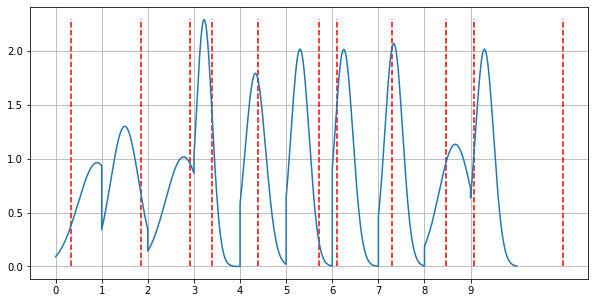

In [14]:
plot_posterior(means, stds, ground_truth=pref)

In [15]:
from math import pi
from scipy.stats import geom

In [16]:
# n_samples = 100

In [17]:
expected_rewards, stds = params_to_gaussian(posterior)

In [18]:
expected_rewards

array([0.9       , 0.5       , 0.77777778, 0.22222222, 0.33333333,
       0.3       , 0.25      , 0.33333333, 0.66666667, 0.3       ])

In [19]:
stds

array([0.41352146, 0.30618622, 0.39196316, 0.1737191 , 0.22222222,
       0.19748418, 0.19764235, 0.19245009, 0.35136418, 0.19748418])

In [23]:
a_star_t = np.sort(expected_rewards)[-K]

In [24]:
a_s = np.array([x[0] for x in posterior])
b_s = np.array([x[1] for x in posterior])
ps = beta.cdf(1 / (a_star_t + 1), a=a_s, b=b_s)
# ps

In [26]:
ps

array([0.61975905, 0.21487897, 0.49155075, 0.02783619, 0.07639538,
       0.0504297 , 0.04510168, 0.05183633, 0.37283006, 0.0504297 ])

In [27]:
# top_k = K
# best_actions = np.sort(
#         np.argpartition(np.transpose(posterior_samples), -top_k, axis=1)[:, -top_k:], axis=1
#         )
# top_actions_dist = np.zeros(posterior_samples.shape)
# for sample_ix in range(n_samples):
#     top_actions_dist[best_actions[sample_ix], sample_ix] = 1.0
# ps = top_actions_dist.mean(1)
entropies_start = - (ps * np.log(np.maximum(ps,1e-12)) + (1 - ps) * np.log(np.maximum(1 - ps, + 1e-12)))
# posterior_samples[best_actions]

In [28]:
entropies_start

array([0.66418196, 0.5203496 , 0.69300439, 0.12713817, 0.26987612,
       0.19977854, 0.18383166, 0.20388711, 0.66044472, 0.19977854])

In [29]:
posterior_samples = 1 / beta.rvs(a=a_s, b=b_s) - 1
observations_samples = geom.rvs(1 / (posterior_samples + 1))#, size=(posterior_samples.shape[0],
#                                                                    posterior_samples.shape[1],
#                                                                    n_samples)) - 1
# entropies_start = 0.5 * np.log(2 * pi * np.exp(1) * stds ** 2)
# new_as = [[(posterior[i][0] + 1, posterior[i][1] + observations_samples[i][j]) for j in range(n_samples)] for i in range(N)]
# new_as = np.array([posterior[i][0] for i in range(N)]).reshape(-1, 1)
new_as = np.ones(observations_samples.shape)
new_bs = np.copy(observations_samples)
for i in range(N):
    new_bs[i] += posterior[i][1]
    new_as[i] += posterior[i][0]
# new_bs, new_as

In [30]:
ps = beta.cdf(1 / (a_star_t + 1), a=new_as, b=new_bs)

In [31]:
ps

array([0.63503776, 0.25653224, 0.51628423, 0.0504297 , 0.10885247,
       0.07562452, 0.07639538, 0.07274392, 0.40498358, 0.32707313])

In [32]:
entropies_end =- (ps * np.log(np.maximum(ps,1e-12)) + (1 - ps) * np.log(np.maximum(1 - ps, + 1e-12)))

In [33]:
entropies_start

array([0.66418196, 0.5203496 , 0.69300439, 0.12713817, 0.26987612,
       0.19977854, 0.18383166, 0.20388711, 0.66044472, 0.19977854])

In [34]:
entropies_end

array([0.65621996, 0.56939841, 0.69261673, 0.19977854, 0.3441094 ,
       0.26795065, 0.26987612, 0.26067947, 0.67498066, 0.63208647])

In [35]:
(entropies_start - entropies_end)

array([ 7.96199803e-03, -4.90488042e-02,  3.87659726e-04, -7.26403663e-02,
       -7.42332793e-02, -6.81721086e-02, -8.60444650e-02, -5.67923585e-02,
       -1.45359394e-02, -4.32307929e-01])

In [36]:
# a_s = np.array([x[0] for x in posterior]).reshape(-1, 1)
# b_s = np.array([x[1] for x in posterior]).reshape(-1, 1)

# posterior_samples = 1 / beta.rvs(a=a_s, b=b_s, size=(a_s.shape[0], n_samples)) - 1

# observations_samples = geom.rvs(1 / (posterior_samples + 1)) - 1

# # new_as = np.ones((N, n_samples), dtype=int)

# new_posteriors = [[(posterior[i][0] + 1, posterior[i][1] + observations_samples[i][j]) for j in range(n_samples)] for i in range(N)]


# new_entropies = [
#     [0.5 * np.log(2 * pi * np.exp(1) * std ** 2) for std in params_to_gaussian(new_posteriors[i])[1]]
#     for i in range(N)
# ]

# new_entropies = np.array(new_entropies)

# new_entropies = new_entropies.mean(1)

reductions = (entropies_start - entropies_end)
reductions

array([ 7.96199803e-03, -4.90488042e-02,  3.87659726e-04, -7.26403663e-02,
       -7.42332793e-02, -6.81721086e-02, -8.60444650e-02, -5.67923585e-02,
       -1.45359394e-02, -4.32307929e-01])

In [39]:
from ts_agents import EpochSamplingTS
ts_cs_agent = EpochSamplingTS(k=K, n=N, horizon=10000, sampling=1, limited_prefs=False)
ts_cs_agent.posterior_parameters = [a_s, b_s]

Agent believes first=best? False


In [40]:
ts_cs_action = ts_cs_agent.proposal()
ts_cs_action

array([0, 2])

In [41]:
from ids_utils import info_gain_step, numba_expected_reward
from env import act_optimally

In [42]:
posterior_samples = np.transpose(posterior_samples)

In [43]:
# sorted_beliefs = np.sort(posterior_samples, axis=1)[
#     :, -K :
# ]  # shape (m, k)
# picking_probabilities = sorted_beliefs.sum(1)
# r_star = picking_probabilities.mean()
# a_greedy = act_optimally(
#     posterior_samples.mean(0), K
# )
# greedy_expected_reward = numba_expected_reward(
#     posterior_samples, a_greedy, mode="step"
# )
# delta_min = r_star - greedy_expected_reward
# assert delta_min > -1e-12
# delta_min = max(1e-12, delta_min)

# posteriors_actions = act_optimally(
#     posterior_samples, K
# )
# posteriors_actions = [
#     tuple(posteriors_actions[ix, :]) for ix in range(n_samples)
# ]
# optimal_actions_information = defaultdict(list)
# for ix, action in enumerate(posteriors_actions):
#     optimal_actions_information[action].append(ix)

# optimal_actions = {
#     action: (len(theta_idxs) / n_samples, theta_idxs)
#     for action, theta_idxs in optimal_actions_information.items()
# }
# actions_star = np.array(
#     [list(key) for key in optimal_actions_information.keys()]
# )
# counts_star = np.array(
#     [len(val) for val in optimal_actions_information.values()]
# )
# thetas_star = []
# for val in optimal_actions_information.values():
#     thetas_star += val
# thetas_star = np.array(thetas_star)
# gain_ts_cs = info_gain_step(action=ts_cs_action,
#                             sampled_preferences=posterior_samples,
#                             actions_star=actions_star,
#                             counts=counts_star,
#                             thetas=thetas_star)

In [44]:
ts_cs_gain = reductions[ts_cs_action].sum()

In [45]:
ts_cs_gain

0.00834965775887786

In [46]:
reductions

array([ 7.96199803e-03, -4.90488042e-02,  3.87659726e-04, -7.26403663e-02,
       -7.42332793e-02, -6.81721086e-02, -8.60444650e-02, -5.67923585e-02,
       -1.45359394e-02, -4.32307929e-01])

In [122]:
reductions = np.maximum(reductions, 1e-8)

In [123]:
x = cp.Variable(N, pos=True)
rewards = cp.Parameter(N, pos=True)
gains = cp.Parameter(N, pos=True)
exp_regret = K - x @ expected_rewards
exp_gain = x @ gains
information_ratio = cp.quad_over_lin(exp_regret, exp_gain)

In [124]:
# objective = cp.Maximize(expected_rewards @ x )
objective = cp.Minimize(information_ratio)
objective

Minimize(Expression(CONVEX, NONNEGATIVE, ()))

In [126]:
# constraints = [0 <= x, x <= 1, cp.sum(x) == K, x @ reductions >= ts_cs_gain]
constraints = [0 <= x, x <= 1, cp.sum(x) == K]
prob = cp.Problem(objective, constraints,)
rewards.value = expected_rewards
gains.value = reductions
prob.solve(solver='ECOS')

12.434899239231477

In [127]:
x.value

array([9.99999998e-01, 4.46870899e-09, 9.99999972e-01, 1.66738819e-09,
       2.37480608e-09, 2.12972859e-09, 1.81776912e-09, 2.37480608e-09,
       1.35699302e-08, 2.12972859e-09])

In [128]:
act_optimally(
            np.squeeze(x.value), top_k=K
        )

array([0, 2])

In [137]:
m = 5
n = 3
k = 1
synthetic_posterior = np.random.rand(m, n)

In [138]:
synthetic_posterior


array([[0.19994982, 0.68826494, 0.54119434],
       [0.23787169, 0.84203066, 0.40131969],
       [0.58004044, 0.21640473, 0.66322928],
       [0.17273202, 0.87153385, 0.42794767],
       [0.61700561, 0.20645943, 0.61093912]])

In [141]:
np.sort(synthetic_posterior, axis=1)

array([[0.19994982, 0.54119434, 0.68826494],
       [0.23787169, 0.40131969, 0.84203066],
       [0.21640473, 0.58004044, 0.66322928],
       [0.17273202, 0.42794767, 0.87153385],
       [0.20645943, 0.61093912, 0.61700561]])

In [146]:
thresholds = np.sort(synthetic_posterior, axis=1)[:, -k].reshape(-1, 1)

In [147]:
thresholds

array([[0.68826494],
       [0.84203066],
       [0.66322928],
       [0.87153385],
       [0.61700561]])

In [149]:
mask = synthetic_posterior >= thresholds

In [153]:
synthetic_posterior * mask

array([[0.        , 0.68826494, 0.        ],
       [0.        , 0.84203066, 0.        ],
       [0.        , 0.        , 0.66322928],
       [0.        , 0.87153385, 0.        ],
       [0.61700561, 0.        , 0.        ]])

In [152]:
(synthetic_posterior * mask).sum(0) / (mask.sum(0))

array([0.61700561, 0.80060982, 0.66322928])

In [154]:
expectations = synthetic_posterior.mean(0)
expectations

array([0.36151992, 0.56493872, 0.52892602])

In [158]:
if_star = (synthetic_posterior * mask).sum(0) / mask.sum(0)
if_star

array([0.61700561, 0.80060982, 0.66322928])

In [161]:
p_star = mask.sum(0) / mask.shape[0]
p_star

array([0.2, 0.6, 0.2])

In [163]:
else_star = (synthetic_posterior * (1 - mask)).sum(0) / (1 - mask).sum(0)
else_star

array([0.29764849, 0.21143208, 0.49535021])

In [164]:
p_star * (if_star - expectations) ** 2 + (1 - p_star) * (else_star - expectations) ** 2

array([0.01631824, 0.0833113 , 0.00450934])

In [165]:
from cvxpy import ROBUST_KKTSOLVER

In [167]:
cp.SolverError

cvxpy.error.SolverError